<a href="https://colab.research.google.com/github/serereuk/RA_code/blob/master/13%EC%A3%BC%EC%B0%A8/bilearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
data = files.upload()

Saving khc1.txt to khc1.txt


In [0]:
import pandas as pd
import numpy as np
import os
os.chdir('/content')
dataname = 'khc1'
names = '_'+dataname+'1_constrain'
data = pd.read_csv(dataname+".txt")

In [0]:
x = data.ALX.diff(); X = data.BLX.diff()
y = data.ALY.diff(); Y = data.BLY.diff()
x[0] = 0; y[0] = 0; X[0] = 0; Y[0] = 0
data['distance'] = (np.sqrt(x**2 + y**2)+np.sqrt(X**2 + Y**2))*0.5

In [0]:
def timecut(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "X2": data.BLX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y2": data.BLX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]})
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps
  
def constrain(data):
  data['X2'] = data.X**2
  data['Y2'] = data.Y**2
  data = data.loc[data.X2 <= 1]
  data = data.loc[data.Y2 <= 1]
  return data

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
from tqdm import tnrange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

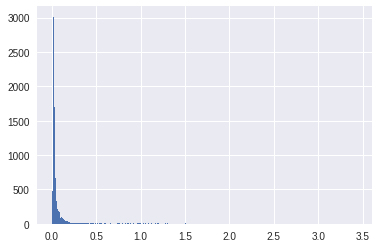

In [0]:
height, row, _  = plt.hist(data.distance, bins = 1000)
cutoff = row[np.where(np.cumsum(height)/data.shape[0] > 0.95)[0][0]]

In [0]:
cutoff

0.42520022912946626

In [0]:
batch_size = 64
epoch = 5000
H = 150
import os
os.chdir('/content')

In [0]:
import shutil
try:
  os.mkdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+names)
  os.chdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+names)
except Exception as E:
  os.chdir('/content')
  shutil.rmtree('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+names)
  os.mkdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+names)
  os.chdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+names)
  pass

In [0]:
from torch.utils.data import Dataset, DataLoader

class dss(Dataset):
    def __init__(self, a):
        np.random.seed(1234)
        a = timecut(a)[['X', 'X2', 'Y', 'Y2', 'x', 'y']]
        #a = constrain(a)
        self.len = a.shape[0]
        self.x_data = torch.from_numpy(a[['X', 'Y','X2', 'Y2']].values).float()
        self.y_data = torch.from_numpy(a[['x', 'y']].values).float()
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

data = data.loc[data.distance <= cutoff]
size = len(data)
indices = list(range(size))
split = int(np.floor(0.1 * size))
np.random.seed(123)
np.random.shuffle(indices)


train_indices, test_indices = indices[split:], indices[:split]
train_data=data.iloc[train_indices, :]
test_data = data.iloc[test_indices, :]
dstrain = dss(train_data)
dstest = dss(test_data)
trainloader = DataLoader(dataset = dstrain, batch_size = batch_size, shuffle = True)
testloader = DataLoader(dataset = dstest, batch_size = 1000, shuffle = True)
device = torch.device("cuda:0")

In [0]:
train_data.shape, test_data.shape, data.shape

((23388, 21), (2598, 21), (25986, 21))

In [0]:
class optim1(nn.Module):
    
    def __init__(self, inputs, H,outputs):
        super(optim1, self).__init__()
        self.linear1 = torch.nn.Linear(inputs, H).cuda()
        self.linear11 = torch.nn.Linear(inputs, H).cuda()
        self.linear2 = torch.nn.Linear(H*2, H).cuda()
        self.linear3 = torch.nn.Linear(H, H).cuda()
        self.linear4 = torch.nn.Linear(H, H).cuda()
        self.linear5 = torch.nn.Linear(H, H).cuda()
        self.linear6 = torch.nn.Linear(H, H).cuda()
        self.linear7 = torch.nn.Linear(H, H).cuda()
        self.linear8 = torch.nn.Linear(H, outputs).cuda()
        
    def forward(self, x, x2):
        h_relu = torch.relu(self.linear1(x))
        h_relu2 = torch.relu(self.linear11(x2))
        h_relu = torch.cat((h_relu, h_relu2), dim = 1)
        h_relu = torch.relu(self.linear2(h_relu))
        h_relu = torch.relu(self.linear3(h_relu))
        h_relu = torch.relu(self.linear4(h_relu))
        h_relu = torch.relu(self.linear5(h_relu))
        h_relu = torch.relu(self.linear6(h_relu))
        h_relu = torch.relu(self.linear7(h_relu))
        y_pred = torch.sigmoid(self.linear8(h_relu))
        return y_pred
        

In [0]:
inputs, outputs = 2, 2
for_graph = []; test_loss = []

model = optim1(inputs, H, outputs)
criteria = torch.nn.L1Loss(size_average= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for t in tnrange(epoch):
    for i, datas in enumerate(trainloader):
        In, label = datas
        In2 = In[:,2:4]
        In = In[:,0:2] 
        In, In2, label = V(In), V(In2), V(label)
        In, In2, label = In.cuda(), In2.cuda(), label.cuda()
        y_pred = model(In, In2)
        loss = criteria(y_pred, label)
        if t % 100 == 99:
            for_graph.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 99:
            with torch.no_grad():
                for datass in testloader:
                    In, label = datass
                    In2 = In[:,2:4]
                    In = In[:,0:2]
                    In, In2, label = In.cuda(), In2.cuda(), label.cuda()
                    outputs = model(In, In2)
                    test_loss.append(np.mean((label.cpu().numpy() - outputs.cpu().numpy())**2))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


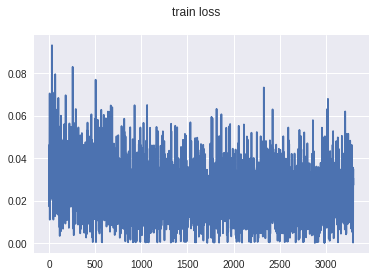

In [0]:
plt.plot(np.arange(len(for_graph)), for_graph)
plt.suptitle('train loss')
plt.savefig('train ' + 'batch_size '+ str(batch_size) + ' epoch '+str(epoch)+' node '+str(H) + ' model optim1.jpg')

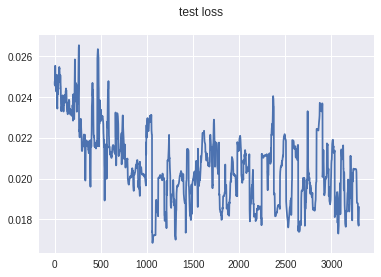

In [0]:
plt.plot(np.arange(len(test_loss)), test_loss)
plt.suptitle('test loss')
plt.savefig('test ' + 'batch_size '+ str(batch_size) + ' epoch '+str(epoch)+' node '+str(H) + ' model optim1.jpg')

In [0]:
min(for_graph), for_graph[-1]

(0.00014327967073768377, 0.0348500981926918)

In [0]:
sum(data.AFX < 0.0166)

1124

### 시각화

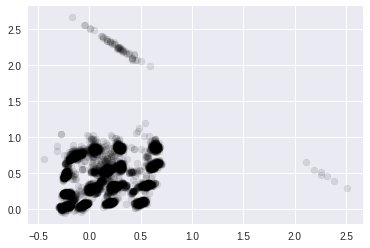

In [0]:
plt.scatter(data.loc[data.ATT < 85].ALX, data.loc[data.ATT < 85].ALY, c = "black", alpha = 0.1)
plt.savefig('khc1_eyeA.jpg')

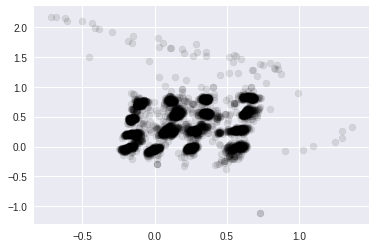

In [0]:
plt.scatter(data.loc[data.ATT < 85].BLX, data.loc[data.ATT < 85].BLY, c = "black", alpha = 0.1)
plt.savefig('khc1_eyeB.jpg')

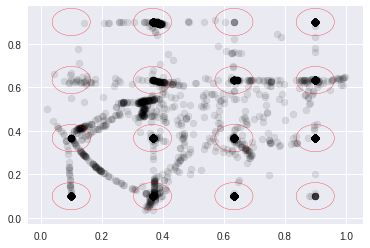

In [0]:
datas = data.loc[data.ATT < 82]
out = pd.DataFrame(model(torch.from_numpy(datas[['ALX', 'ALY']].values).float().cuda(),
                        torch.from_numpy(datas[['BLX', 'BLY']].values).float().cuda() ).detach().cpu().numpy())
ax = plt.gca()
plt.scatter(out.iloc[:,0], out.iloc[:,1], color= 'black', alpha = 0.1)
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct0.jpg')

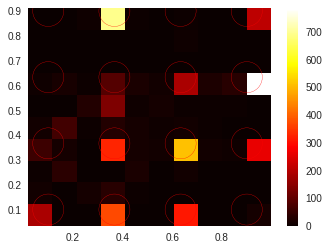

In [0]:
ax = plt.gca()
ax.grid(False)
heatmap, xedge, yedge = np.histogram2d(out.iloc[:,0], out.iloc[:,1])
extent = [xedge[0], xedge[-1], yedge[0], yedge[-1]]
img = ax.imshow(heatmap.T,extent=extent, origin='lower', cmap = plt.cm.hot)
plt.colorbar(img, ax=ax)
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct.jpg')

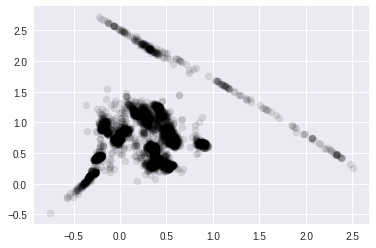

In [0]:
plt.scatter(data.loc[data.ATT >data.ATT.tolist()[-1] - 84].ALX, data.loc[data.ATT >data.ATT.tolist()[-1] - 84].ALY, c = "black", alpha = 0.1)
plt.savefig('khc1_eyeA2.jpg')

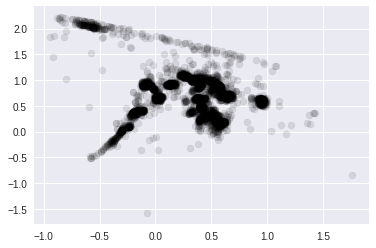

In [0]:
plt.scatter(data.loc[data.ATT >data.ATT.tolist()[-1] - 84].BLX, data.loc[data.ATT >data.ATT.tolist()[-1] - 84].BLY, c = "black", alpha = 0.1)
plt.savefig('khc1_eyeB2.jpg')

In [0]:
datas2 = data.loc[data.ATT > data.ATT.tolist()[-1] - 84]

In [0]:
datas2.shape

(4536, 21)

In [0]:
out = pd.DataFrame(model(torch.from_numpy(datas2[['ALX', 'ALY']].values).float().cuda(),
                        torch.from_numpy(datas2[['BLX', 'BLY']].values).float().cuda() ).detach().cpu().numpy())


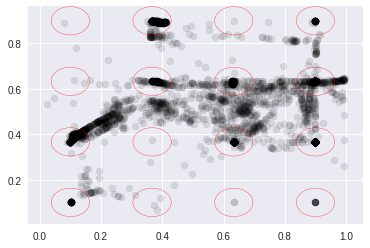

In [0]:
ax = plt.gca()

ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black", alpha = 0.1)
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct2.jpg')

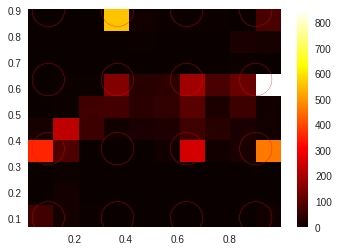

In [0]:
ax = plt.gca()
ax.grid(False)
heatmap, xedge, yedge = np.histogram2d(out.iloc[:,0], out.iloc[:,1])
extent = [xedge[0], xedge[-1], yedge[0], yedge[-1]]
img = ax.imshow(heatmap.T,extent=extent, origin='lower',cmap = plt.cm.hot)
plt.colorbar(img, ax=ax)
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct3.jpg')

In [0]:
#!zip -r /content/file.zip /content
#from google.colab import files
#files.download("/content/file.zip")